This notebook explores SNMR data and demonstrates an approach to estimating aquifer properties for a near surface aquifer. Presently it is a little messy but I intend on cleaning it up post AGC conference

Neil Symington

neil.symington@ga.gov.au

In [2]:
from sqlite3 import dbapi2 as sqlite
import pandas as pd
from shapely.geometry import Polygon, shape
from shapely import wkt
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils, SNMR_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import os
import math
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import rasterio
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
from hydrogeol_utils.db_utils import makeCon, closeCon

In [160]:
# This function extracts the K profile using the SDR equation

def SDR_K(df, C = 4000):
    '''
    df: dataframe containing GMR inversion data
    N: empirical exponent for water content when estimating the water content
    C: empirical constant for estimating water content
    '''
    return C * (df['Total_water_content'].values) * (df['T2*'].values)

def objective_function(df, C, equation= 'SDR', loss_fn = 'L2'):
    if equation == 'SDR':
        # Find an estimate of log10 K
        df['SNMR_K'] = SDR_K(df, C = C)
    if equation == 'TC':
        # Find an estimate of log10 K
        df['SNMR_K'] = TC_K(df, C = C)
    # Retrun the sum of the squares
    if loss_fn == 'L2':
        return ((df['SNMR_K'] - df['K'])**2).sum()
    if loss_fn == 'L1':
        return (np.abs(df['SNMR_K'] - df['K'])).sum()
    
def point_within_bounds(x,y, bounds):
    if (bounds.left < x) & (bounds.right > x):
        if (bounds.bottom < y) & (bounds.top > y):
            return True
    return False

In [161]:
# Our next tak is to bring the SNMR data in 

# Connect to the SNMR database

# Now we want to know the screened interval and other spatial information so we open up the 
# borehole database


SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']


DB_PATH = r"C:\Users\PCUser\Desktop\EK_data\SNMR\East_Kimberley_SNMR.sqlite"

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()

query = """

SELECT
              s.site_id,
              s.Field_ID,
              s.mid_X,
              s.mid_Y,
              a.acquisition_id,
              s.geometry,
              s.elevation,
              a.pulse_sequence,
              a.pulse_length,
              imm.Depth_of_Investigation
              
FROM 

             sites as s
             JOIN acquisitions as a on s.site_id=a.site_id
             JOIN inverse_model_metadata as imm on a.acquisition_id = imm.acquisition_id

WHERE

            a.pulse_sequence == "FID";"""

df_acquisitions = pd.read_sql_query(query, connection, index_col = 'acquisition_id')

# Since we are interested in the shallow resolution we will use the shorter pulse SNMR


df_acquisitions = df_acquisitions.loc[SNMR_utils.choose_snmr_site_acquisition(df_acquisitions,
                                 pulse_sequence_criteria = ['FID'],
                                 pulse_length_criteria="max")]



In [162]:
# remove some nulls

df_acquisitions.at[:,'elevation'] = df_acquisitions['elevation'].replace('-9999.0', np.nan).astype(np.float)

In [163]:
inv_id

40

In [164]:
# Now extract the SNMR inversions

acquisition_ids = df_acquisitions.index

cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id']

df_inversions= SNMR_utils.extract_snmr_inversions(acquisition_ids, connection,
                                                  mask_below_doi = True)[cols]

# And the inversion metadata

# We also have an inversion metadata table, here I will pull out the metadata for 
# the inversion above

# Find the site_id

inv_id = df_inversions.inversion_id.unique()

query = "SELECT * FROM inverse_model_metadata;"


# A bug means I cannot pass params but I can pass (254,255)
df_inversion_metadata = pd.read_sql_query(query, connection)


In [165]:
df_acquisitions

,site_id,Field_ID,mid_X,mid_Y,geometry,elevation,pulse_sequence,pulse_length,Depth_of_Investigation
acquisition_id,,,,,,,,,
0,0,MillProf,466505.9100,8316696.170,"POLYGON ((466296.2798914838 8316647.306548808,...",51.909279,FID,40.0,45.148358
2,1,saltflats_st1,468448.6660,8354121.638,"POLYGON ((468500.9411914838 8354169.254548808,...",3.142112,FID,40.0,24.773026
3,2,2pm,468863.3010,8347878.272,"POLYGON ((468914.1478914838 8347926.009548808,...",44.433735,FID,40.0,79.434384
5,3,7m,464216.0790,8350319.661,"POLYGON ((464250.9278914838 8350216.810548807,...",18.368710,FID,40.0,79.434384
7,4,6m,458571.4590,8345568.043,"POLYGON ((458622.3728914838 8345611.113548808,...",62.885246,FID,40.0,74.430066
...,...,...,...,...,...,...,...,...,...
415,261,OK18_70,499206.4563,8286306.341,"POLYGON ((499258.881652 8286248.88157, 499148....",19.483648,FID,80.0,71.189093
416,262,OK18_75,522306.2338,8301356.083,"POLYGON ((522358.636074 8301298.60235, 522248....",11.542414,FID,80.0,66.368816
417,263,OK18_76,500099.6412,8295239.253,"POLYGON ((500047.209849 8295296.70649, 500157....",19.070965,FID,80.0,71.189093


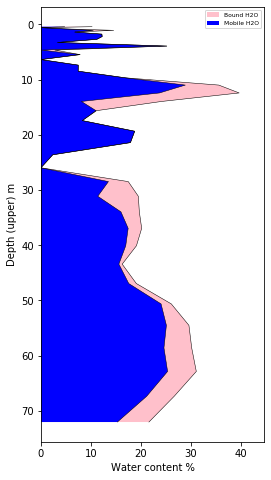

In [166]:
# PLot an SNMR water content profile
# Finally lets plot an inversion

fig, ax1 = plt.subplots(1,1, sharey=True, figsize = (4,8))

inv_id = 40

ax1 = SNMR_utils.plot_profile(ax1, df_inversions[df_inversions['inversion_id']==inv_id],
                              doi = None,  plot_mobile_water = True)

plt.gca().invert_yaxis()
plt.show()


In [167]:
# Bring in the slug test processed K values

infile = r"C:\Users\PCUser\Desktop\EK_data\Boreholes\EK_slug_test_K_processed.csv"

df_slug = pd.read_csv(infile)

print(df_slug)

   borehole_id     log_K     Easting     Northing Borehole_name  \
0       635728  1.711760  520144.760  8306293.880      RN040873   
1       635735 -0.102018  505309.448  8293856.701      RN040878   
2       635737  0.134896  507769.229  8299897.749      RN040884   
3       635740  2.417096  500053.109  8296644.456      RN040882   
4       635741  1.860120  500049.774  8295302.212      RN040876   
5       635742  1.206960  500054.317  8293767.687      RN040875   

  Alternative_name  Ground_elevation_mAHD  Depth_from  Depth_to  \
0             KR08                  7.519          31        37   
1             KR33                 16.494          36        42   
2             KR38                 12.462          29        35   
3             KR46                 18.357          17        23   
4             KR48                 19.046          20        26   
5             KR49                 19.951          29        35   

  Construction_name         stratigraphy  
0            scre

In [168]:
# Now we do a spatial query to find the representative SNMR observations


SNMR_coords = df_acquisitions[['mid_X', 'mid_Y']].values

distances, indices = spatial_functions.nearest_neighbours(df_slug[['Easting', 'Northing']],
                                                         SNMR_coords,
                                                         points_required = 1,
                                                         max_distance = 200.)

In [169]:
df_coloc_bores = df_slug.copy()

df_coloc_bores['colocated_SNMR_acqu_id'] = -999

# Iterate through the bores and if a site was returned
# add the site id to the dataframe
for i, (index, row)  in enumerate(df_coloc_bores.iterrows()):
    idx = indices[i]
    if idx != len(df_acquisitions):
        # Since we only have one acquisition per site we can use site_id
        df_coloc_bores.at[index, 'colocated_SNMR_acqu_id'] = idx
        
# Remove the bores with no location

df_coloc_bores = df_coloc_bores[df_coloc_bores['colocated_SNMR_acqu_id'] != -999]

# Get the SNMR site_ids

SNMR_ids = df_coloc_bores['colocated_SNMR_acqu_id'].unique()

# Trim the inversions

df_inversions_subset = df_inversions[df_inversions['acquisition_id'].isin(SNMR_ids)]

df_inversions_subset=  df_inversions_subset.merge(df_acquisitions[df_acquisitions.index.isin(SNMR_ids)], 
                                              how='inner', left_on='acquisition_id',
                                              right_index=True, )

In [170]:
df_coloc_bores

,borehole_id,log_K,Easting,Northing,Borehole_name,Alternative_name,Ground_elevation_mAHD,Depth_from,Depth_to,Construction_name,stratigraphy,colocated_SNMR_acqu_id
0,635728,1.711760,520144.760,8306293.880,RN040873,KR08,7.519,31,37,screen,Cenozoic sediments,223
1,635735,-0.102018,505309.448,8293856.701,RN040878,KR33,16.494,36,42,screen,Permo-Carboniferous,213
2,635737,0.134896,507769.229,8299897.749,RN040884,KR38,12.462,29,35,screen,Permo-Carboniferous,217
3,635740,2.417096,500053.109,8296644.456,RN040882,KR46,18.357,17,23,screen,Cenozoic sediments,215
4,635741,1.860120,500049.774,8295302.212,RN040876,KR48,19.046,20,26,screen,Cenozoic sediments,127
5,635742,1.206960,500054.317,8293767.687,RN040875,KR49,19.951,29,35,screen,Cenozoic sediments,253


In [171]:
# For each bore with slug test results we will find all of the SNMR observations
# for the screened interval and average them and add them to the merge dataframe

# Define the columns to add to the dataframe
cols = ['Mobile_water_content', 'Bound_water_content',
        'Total_water_content', 'T2*']

for c in cols:
    df_coloc_bores[c] = np.nan

for index, row in df_coloc_bores.iterrows():
    
    # Subset the interpreted dataframe
    SNMR_key = row.colocated_SNMR_acqu_id
    
   
    # Get the stratigraphy for the borehole and average
    df_temp = df_inversions_subset[df_inversions_subset['acquisition_id'] == SNMR_key]
    
    # Subset based on the screenen interval and average
    
    mask = (df_temp['Depth_from'] >= row.Depth_from) & \
           (df_temp['Depth_to'] <= row.Depth_to)
    
    interval_SNMR = df_temp[mask].mean()
    
    # Add this to the df_merged dataframe
    df_coloc_bores.at[index, cols] = interval_SNMR[cols]
    
# Remove any nulls where the screen didn't intersect the layered model
df_coloc_bores.dropna(how="any", subset = cols, inplace = True)

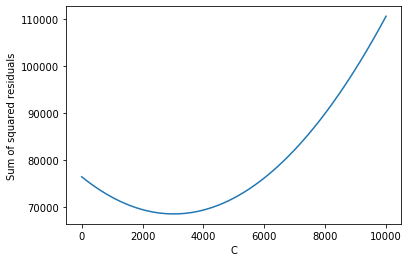

Optimal value of C is 3024


In [210]:

# Now we have the data we can easily estimate the hydraulic conductivity from 
# for values of C and use this to find the optimal value of C for each formation

df_opt = df_coloc_bores.copy()


# Do a linear transform

df_opt['K'] = 10**df_opt['log_K']

# Scan a number of different C values

C_vals = np.arange(0,10000, 1)

sum_of_squares = np.nan*np.ones(shape = C_vals.shape)

for i, c in enumerate(C_vals):
    sum_of_squares[i] = objective_function(df_opt, c, equation= 'SDR', loss_fn = 'L2')

# Explore the results

# Find the C that produces the minimum of the residuals

best_C = C_vals[np.argmin(sum_of_squares)]
plt.close()
plt.plot(C_vals,sum_of_squares)
plt.ylabel('Sum of squared residuals')
plt.xlabel('C')
plt.show()

print("Optimal value of C is" , best_C)

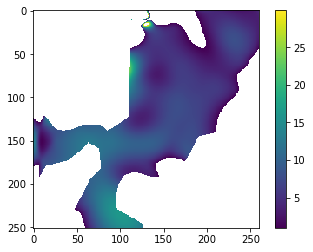

In [180]:
# Now lets subset the SNMR data into the Keep River area where we have a water
# table map to differentiate saturated from unsaturated

wt_infile = r"C:\Users\PCUser\Desktop\EK_data\Interp\WaterTable\KR_wt_depth_clipped.tif"

wt_src = rasterio.open(wt_infile)
wt_arr = wt_src.read()[0]

# Romve null values

null = -3.4028235e+38

wt_arr[np.isclose(wt_arr, null)] = np.nan

plt.imshow(wt_arr)
plt.colorbar()
plt.show()


In [181]:
# Now we keep only points that fall within this water table map
# TODO get a better solutions - get polygon of water table map

wt_bounds = wt_src.bounds

df_acquisitions['wt_depth'] = np.nan

# Iterate through the sites and add the raster value to the dataframe
# if it is within the extent of the raster
for index, row in df_acquisitions.iterrows():
    # get the coords
    x, y = row.mid_X, row.mid_Y
    # Check if point is within bounds - HACK!
    if point_within_bounds(x,y, wt_bounds):
        
        wt = next(wt_src.sample(np.array([[x,y]])))[0]
        

        if not np.isclose(wt,-3.4028235e+38):
            df_acquisitions.at[index, 'wt_depth'] = wt

# Drop null columns

df_acquisitions_Keep = df_acquisitions.dropna(how = 'any', subset = ['wt_depth'])

In [201]:
# Now get the SNMR inversions from this area, clip it to the water table

df_Keep = df_inversions[df_inversions['acquisition_id'].isin(df_acquisitions_Keep.index)]

df_Keep = df_Keep.join(df_acquisitions, on = 'acquisition_id')

# Create mask for if water table depth is more than depth to

mask = df_Keep['Depth_from'] < df_Keep['wt_depth']


In [202]:
# Create a saturated or unsaturated label

df_Keep['label'] = 'unsaturated'

df_Keep.at[df_Keep[mask].index, 'label'] = 'saturated' 

In [205]:
# Calculate K

df_Keep['K'] = SDR_K(df_Keep, C = best_C)

In [206]:
# Find log K

logK = np.log10(df_Keep[df_Keep['label'] == 'saturated']['K'].values)

# Romve infinities which are divide by zero errors
logK[logK==-np.inf]=np.nan

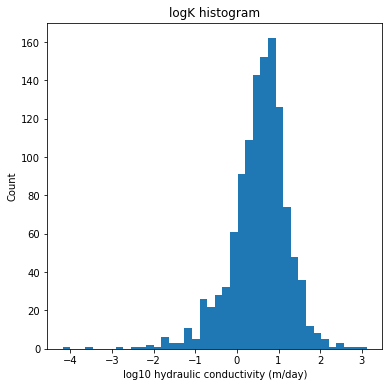

In [207]:
# Plot
fig, ax = plt.subplots(1,1, figsize = (6,6))
ax.hist(logK, bins = 40)
ax.set_title('logK histogram')
ax.set_ylabel('Count')
ax.set_xlabel('log10 hydraulic conductivity (m/day)')
plt.show()

In [208]:
# Export the data for some kind of gridding

df_Keep.to_csv(r"C:\Temp\KeepRiver_logK.csv")